In [24]:
import pandas as pd
import numpy as np
import scipy as sp

In [25]:
import seaborn as sns
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [26]:
accuracy    = np.vectorize(lambda x: x[0] < x[1])
logloss     = np.vectorize(lambda x: x[0] - np.log(np.exp(x[0]) + np.exp(x[1])))
reliability = np.vectorize(lambda x: np.exp(x[0] - x[1]))

In [83]:
def tree_direction_test_statistics(model_lkhd_results, draw_extended_base=False, bins=10):
    yale_results = model_lkhd_results['Yale']['Trivial']
    cab_results = model_lkhd_results['CAB_NoKNeighbours']['Trivial']
    cab_results_extended_base = model_lkhd_results['CAB_NoKNeighbours_extended_base']['Trivial']

    def apply_statistic_to_dataset(dataset, statistic, aggregate):
        results = []
        for tree in dataset:
            if len(tree):
                results.append(aggregate(statistic(tree)))
        return np.array(results)

    def draw_classification_stats_distplot(title, x1, x2, x3=None, xlim_left=None, xlim_right=None, bins=10):
        draw_distplot = (lambda x, color: sns.distplot(x[~np.isnan(x)],
                                                       bins=bins, rug=True, kde=True))
        draw_distplot(x1, color='blue')
        draw_distplot(x2, color='green')
        if x3 is not None:
            draw_distplot(x3)
            plt.legend(['Yale', 'CAB', 'CAB extended'])
        plt.legend(['Yale', 'CAB'])
        ax = plt.gca()
        leg = ax.get_legend()
        leg.legendHandles[0].set_color('blue')
        leg.legendHandles[1].set_color('green')
        plt.title(title)
        if xlim_left is not None and xlim_right is not None:
            plt.xlim(xlim_left, xlim_right)
        plt.savefig('/Users/andrewbzikadze/Desktop/' + title + '.png', format='png', dpi=600)
        plt.show()

    def apply_function(statistic, over_function, title, bins=10, xlim_left=None, xlim_right=None):
        statistic_yale = apply_statistic_to_dataset(yale_results, statistic, over_function)
        statistic_cab  = apply_statistic_to_dataset(cab_results,  statistic, over_function)
        if draw_extended_base:
            statistic_cab_extended_base  = apply_statistic_to_dataset(cab_results_extended_base, 
                                                                      statistic, over_function)
        else:
            statistic_cab_extended_base = None
        draw_classification_stats_distplot(title=title, 
                                           x1=statistic_yale,
                                           x2=statistic_cab,
                                           x3=statistic_cab_extended_base,
                                           bins=bins,
                                           xlim_left=xlim_left,
                                           xlim_right=xlim_right)
        print("Median for yale: " + str(np.median(statistic_yale)))
        print("Median for CAB: "  + str(np.median(statistic_cab)))
        if draw_extended_base:
            print("Median for CAB extended: "  + str(np.median(statistic_cab_extended_base)))
        print("Mann Whitneyu test for equality of means Yale vs Cab:")
        print(sp.stats.mannwhitneyu(statistic_yale, statistic_cab, use_continuity=True))
        print("")
                                                    
    apply_function(accuracy, np.mean, 'accuracy', bins=bins, xlim_left=0, xlim_right=1)
    full_accuracy_yale = apply_statistic_to_dataset(yale_results, accuracy, lambda x: x)
    print("Full accuracy for yale model: " + str(np.mean(np.concatenate(full_accuracy_yale))))
    full_accuracy_cab  = apply_statistic_to_dataset(cab_results,  accuracy, lambda x: x)
    print("Full accuracy for CAB model: "  + str(np.mean(np.concatenate(full_accuracy_cab))))
    if draw_extended_base:
        full_accuracy_cab_extended  = apply_statistic_to_dataset(cab_results_extended_base,  accuracy, lambda x: x)
        print("Full accuracy for CAB model extended bases: "  + str(np.mean(np.concatenate(full_accuracy_cab_extended))))
    
    apply_function(logloss, np.nansum, 'logloss')
    apply_function(reliability, np.nanmedian, 'reliability')

In [39]:
import tree_test_utilities.flu_trees_statistics_calculator as flu_trees_statistics_calculator
import tree_test_utilities.tree_test_utilities as tree_test_utilities
import likelihood_calculator.likelihood_calculator as likelihood_calculator
import shm_kmer_model.shm_kmer_model as shm_kmer_model

In [40]:
flu_calc = flu_trees_statistics_calculator.FluTreesStatisticsCalculator()
tester = tree_test_utilities.TreeTester(minimal_size_filtered_tree=15)

# Tree direction test (Heavy)

In [41]:
# mutability_results_igh   = flu_calc.get_flu_likelihood_statistics(tester, chain_type='IGH', model_mode=shm_kmer_model.ModelMode.Mutation)
# substitution_results_igh = flu_calc.get_flu_likelihood_statistics(tester, chain_type='IGH', model_mode=shm_kmer_model.ModelMode.Substitution)
mut_subst_results_igh    = flu_calc.get_flu_likelihood_statistics(tester, chain_type='IGH', model_mode=shm_kmer_model.ModelMode.Both)

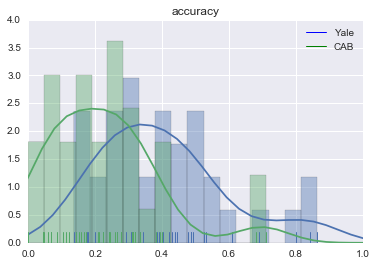

Median for yale: 0.384615384615
Median for CAB: 0.210526315789
Mann Whitneyu test for equality of means Yale vs Cab:
MannwhitneyuResult(statistic=964.0, pvalue=3.7375724071642502e-05)

Full accuracy for yale model: 0.401649746193
Full accuracy for CAB model: 0.231598984772


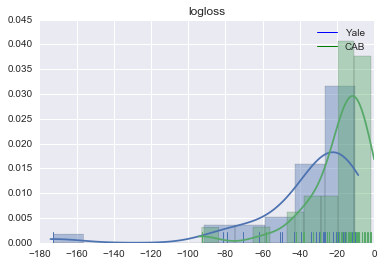

Median for yale: -25.227853439
Median for CAB: -13.6240649861
Mann Whitneyu test for equality of means Yale vs Cab:
MannwhitneyuResult(statistic=313.0, pvalue=0.00044461153408176983)



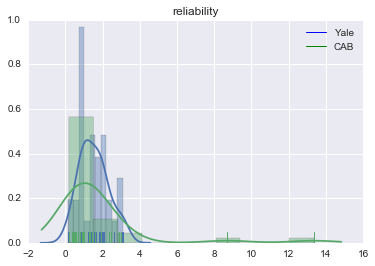

Median for yale: 1.45046458243
Median for CAB: 1.0
Mann Whitneyu test for equality of means Yale vs Cab:
MannwhitneyuResult(statistic=762.0, pvalue=0.079099053770001912)



In [84]:
tree_direction_test_statistics(mut_subst_results_igh, draw_extended_base=False, bins=15)

# Tree direction test (Kappa)

In [45]:
import shm_kmer_model_estimator.standard_model_estimations as standard_model_estimations

In [48]:
flu_calc = flu_trees_statistics_calculator.FluTreesStatisticsCalculator(
    cab_model=standard_model_estimations.full_all_chains_model(),
    cab_model_extended_base=standard_model_estimations.full_all_chains_model())

In [49]:
# mutability_results_igk   = flu_calc.get_flu_likelihood_statistics(tester, chain_type='IGK', model_mode=shm_kmer_model.ModelMode.Mutation)
# substitution_results_igk = flu_calc.get_flu_likelihood_statistics(tester, chain_type='IGK', model_mode=shm_kmer_model.ModelMode.Substitution)
mut_subst_results_igk    = flu_calc.get_flu_likelihood_statistics(tester, chain_type='IGK', model_mode=shm_kmer_model.ModelMode.Both)

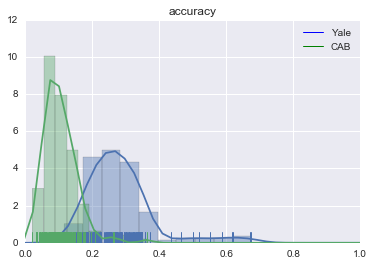

Median for yale: 0.26601930678
Median for CAB: 0.097051152007
Mann Whitneyu test for equality of means Yale vs Cab:
MannwhitneyuResult(statistic=19153.5, pvalue=2.352058531708053e-43)

Full accuracy for yale model: 0.275370769426
Full accuracy for CAB model: 0.103714032197


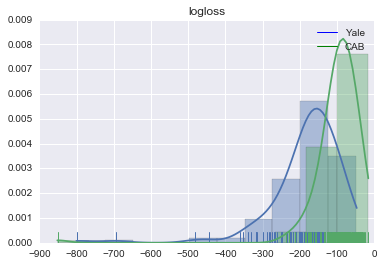

Median for yale: -163.05462662
Median for CAB: -86.5332668497
Mann Whitneyu test for equality of means Yale vs Cab:
MannwhitneyuResult(statistic=3133.0, pvalue=7.5502889213435566e-23)



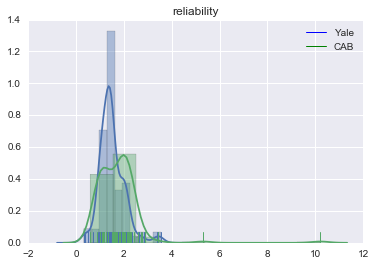

Median for yale: 1.45369834254
Median for CAB: 1.82987052552
Mann Whitneyu test for equality of means Yale vs Cab:
MannwhitneyuResult(statistic=8151.0, pvalue=0.014765999467832755)



In [87]:
tree_direction_test_statistics(mut_subst_results_igk)

# Tree direction test (Lambda)

In [51]:
# mutability_results_lambda   = flu_calc.get_flu_likelihood_statistics(tester, chain_type='IGL', model_mode=shm_kmer_model.ModelMode.Mutation)
# substitution_results_lambda = flu_calc.get_flu_likelihood_statistics(tester, chain_type='IGL', model_mode=shm_kmer_model.ModelMode.Substitution)
mut_subst_results_lambda    = flu_calc.get_flu_likelihood_statistics(tester, chain_type='IGL', model_mode=shm_kmer_model.ModelMode.Both)

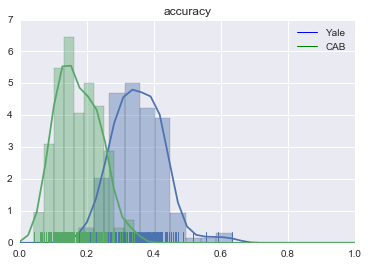

Median for yale: 0.35179526356
Median for CAB: 0.163177717439
Mann Whitneyu test for equality of means Yale vs Cab:
MannwhitneyuResult(statistic=19036.5, pvalue=2.5457544585727132e-42)

Full accuracy for yale model: 0.354535128996
Full accuracy for CAB model: 0.175117637514


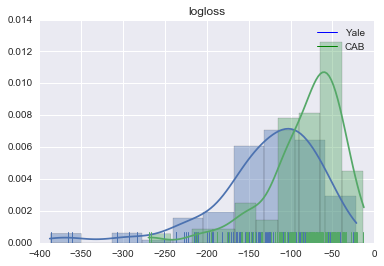

Median for yale: -112.035109124
Median for CAB: -71.1960095971
Mann Whitneyu test for equality of means Yale vs Cab:
MannwhitneyuResult(statistic=5128.0, pvalue=5.3675567152639928e-12)



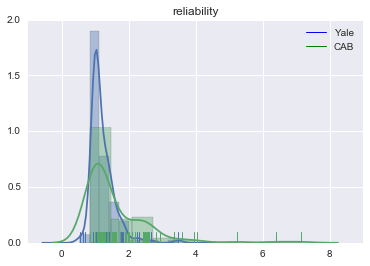

Median for yale: 1.00818963769
Median for CAB: 1.11895622486
Mann Whitneyu test for equality of means Yale vs Cab:
MannwhitneyuResult(statistic=8234.0, pvalue=0.0151057926646789)



In [86]:
tree_direction_test_statistics(mut_subst_results_lambda)

# Germline test (Leukemia, IGH)

In [ ]:
import germline_test_utilities.germline_test_utilities as germline_test_utilities
import shm_kmer_model_estimator.standard_model_estimations as standard_model_estimations 

In [ ]:
tester = germline_test_utilities.GermlineTester()
cab_nokn_igh = standard_model_estimations.full_igh_model()
cab_nokn_igh = cab_nokn_igh['NoKNeighbours']['IGH']
yale_model = shm_kmer_model.YaleSHM_Model()

In [ ]:
cab_nokn_igh_lkhd = tester.get_likelihood_statistics(model=cab_nokn_igh)
yale_lkhd         = tester.get_likelihood_statistics(model=yale_model)

In [ ]:
cab_nokn_igh_accuracy = accuracy(cab_nokn_igh_lkhd)
yale_accuracy = accuracy(yale_lkhd)

In [ ]:
np.mean(cab_nokn_igh_accuracy)

In [ ]:
np.mean(yale_accuracy)

# Germline test (cross-validation)